In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd

from modules.psar import RealtimePSAR

In [3]:
pattern = re.compile(r".+([0-9]{4})([0-9]{2})([0-9]{2})\.xlsx")

In [4]:
name_excel = "../excel/tick_20250618.xlsx"
#ticker = "7011"
#ticker = "7203"
ticker = "8306"

m = pattern.match(name_excel)
if m:
    year = m.group(1)
    month = m.group(2)
    day = m.group(3)
else:
    year = "1970"
    month = "01"
    day = "01"
date_str = f"{year}-{month}-{day}"
df = pd.read_excel(name_excel, sheet_name=ticker)
df

,Time,Price
0,1.750205e+09,1941.5
1,1.750205e+09,1941.5
2,1.750205e+09,1942.0
3,1.750205e+09,1942.0
4,1.750205e+09,1939.0
...,...,...
19367,1.750228e+09,1954.5
19368,1.750228e+09,1954.5
19369,1.750228e+09,1954.5
19370,1.750228e+09,1954.5


In [5]:
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(t) for t in df["Time"]])
df

,Time,Price
2025-06-18 09:00:03.525241,1.750205e+09,1941.5
2025-06-18 09:00:04.528070,1.750205e+09,1941.5
2025-06-18 09:00:05.539068,1.750205e+09,1942.0
2025-06-18 09:00:06.547656,1.750205e+09,1942.0
2025-06-18 09:00:07.552176,1.750205e+09,1939.0
...,...,...
2025-06-18 15:24:55.808900,1.750228e+09,1954.5
2025-06-18 15:24:56.813796,1.750228e+09,1954.5
2025-06-18 15:24:57.807114,1.750228e+09,1954.5
2025-06-18 15:24:58.815008,1.750228e+09,1954.5


In [6]:
def get_psar(df: pd.DataFrame):
    rpsar = RealtimePSAR()
    df_psar = pd.DataFrame({
        "Price": [],
        "Trend": [],
        "PSAR": []
    })
    for t in df.index:
        y = df.at[t, "Price"]
        ret = rpsar.add(y)
        df_psar.at[t, "Price"] = y
        df_psar.at[t, "Trend"] = ret.trend
        df_psar.at[t, "PSAR"] = ret.psar
    ser_bull = df_psar[df_psar["Trend"] > 0]["PSAR"]
    ser_bear = df_psar[df_psar["Trend"] < 0]["PSAR"]
    return ser_bull, ser_bear

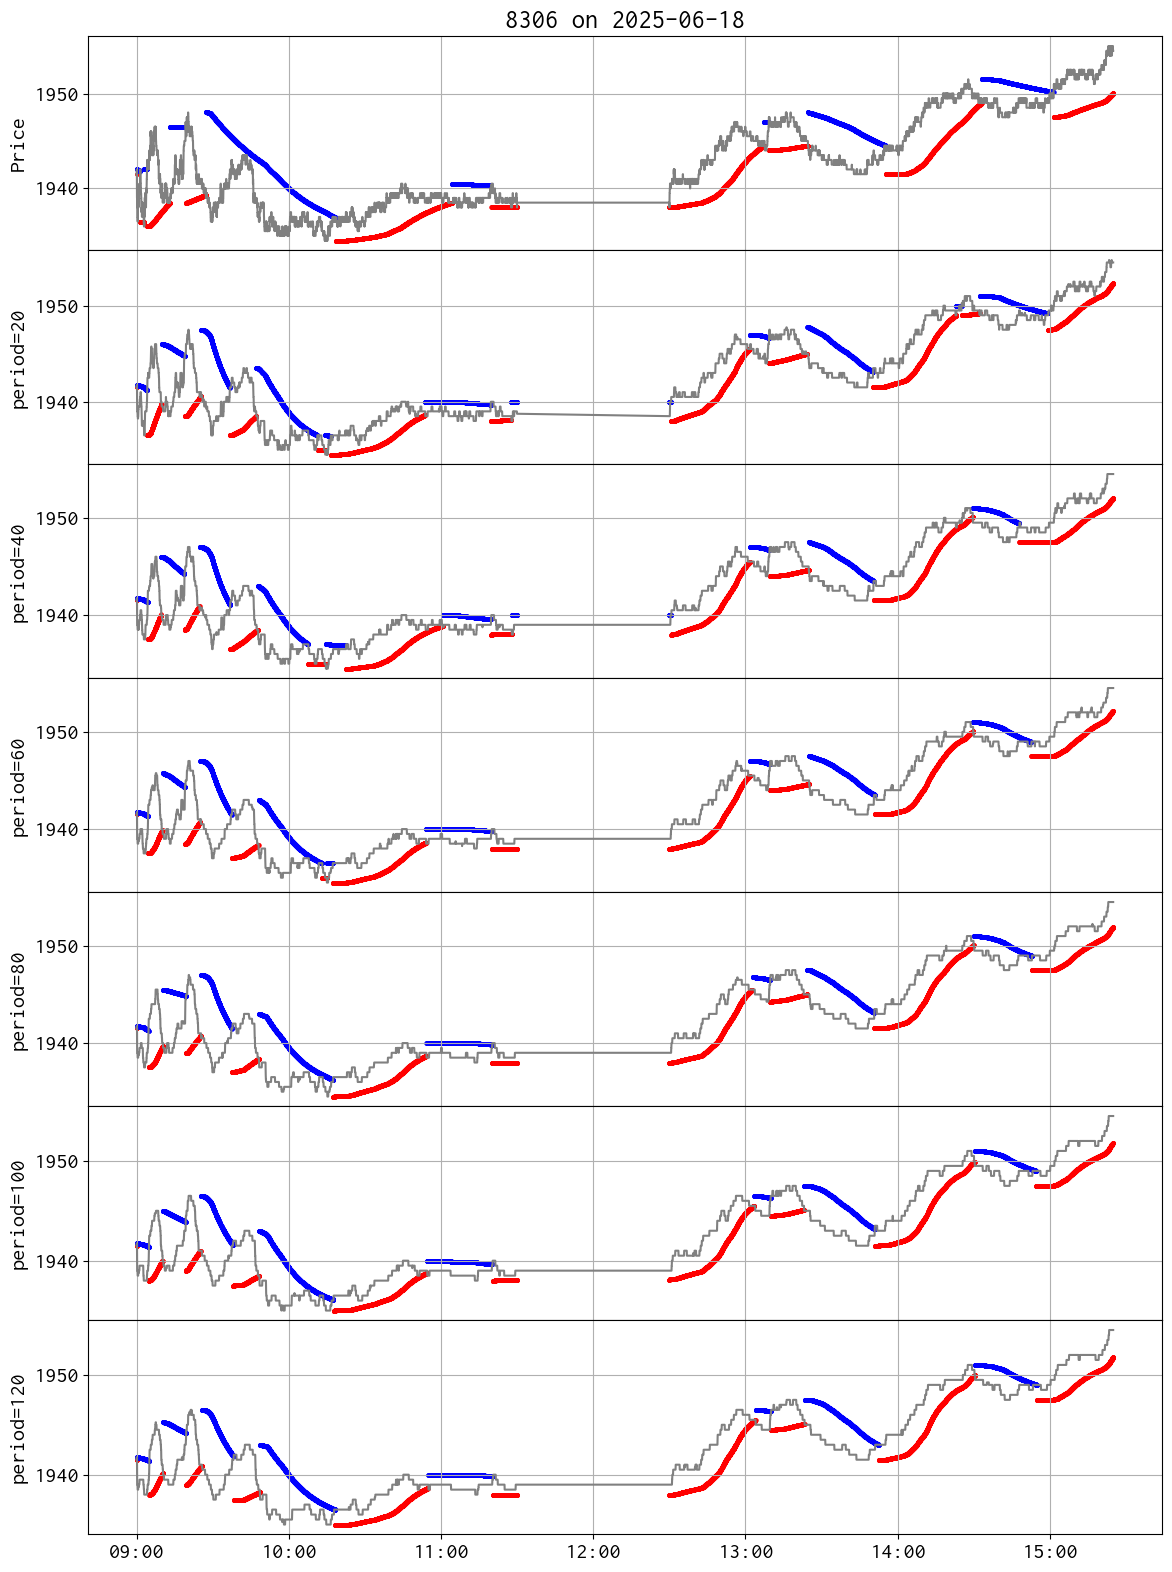

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12, 16))
ax = dict()
n = 7
gs = fig.add_gridspec(
    n, 1, wspace=0.0, hspace=0.0, height_ratios=[1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].plot(df["Price"], color="gray")
ser_bull, ser_bear = get_psar(df)
ax[0].scatter(x=ser_bull.index, y=ser_bull, s=5, c="red")
ax[0].scatter(x=ser_bear.index, y=ser_bear, s=5, c="blue")

ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_ylabel("Price")
ax[0].set_title(f"{ticker} on {date_str}")

factor = 20
for i in range(1, 7):
    df_med = pd.DataFrame(df["Price"].rolling(i * factor, min_periods=1).median())
    ax[i].plot(df_med, color="gray")
    ser_bull, ser_bear = get_psar(df_med)
    ax[i].scatter(x=ser_bull.index, y=ser_bull, s=5, c="red")
    ax[i].scatter(x=ser_bear.index, y=ser_bear, s=5, c="blue")
    
    ax[i].set_ylabel(f"period={factor * i}")

plt.tight_layout()
plt.savefig(f"screenshots/psar_med_{ticker}_{date_str}.png" )
plt.show()